In [93]:
import multiprocessing
import subprocess
import numpy as np
import re
import collections
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
import seaborn as sns
import pandas as pd

%cd /work/kelsey/hgt/test/

/work/kelsey/hgt/test


In [10]:
def run_ranger(scale=1):
    d,t,l = np.asarray([2,3,1])*scale
    subprocess.call(['/work/ranger/CorePrograms/Ranger-DTL.mac',
                     '-i', '4452.input',
                     '-o', '4452.%i.out' % scale,
                     '-D', str(d),
                     '-T', str(t),
                     '-L', str(l)])

In [12]:
pool = multiprocessing.Pool(processes=10)
pool.map_async(run_ranger, range(1, 1001))
pool.close()
pool.join()

In [22]:
grep   = subprocess.getoutput('grep -e "The minimum reconciliation cost is" 4452.*.out')
ratios = []
for scale, cost in re.findall('^4452\.(\d+)\.out:The minimum reconciliation cost is: (\d+)', grep, re.M):
    ratios.append(float(cost)/float(scale))
print(collections.Counter(ratios))

grep   = subprocess.getoutput('grep "Total number of optimal solutions:" 4452.*.out')
optimal_reconciliations = []
for scale, cost in re.findall('^4452\.(\d+)\.out:Total number of optimal solutions: (\d+)', grep, re.M):
    optimal_reconciliations.append(cost)
print(collections.Counter(optimal_reconciliations))

grep   = subprocess.getoutput('grep "Total number of candidates for gene birth:" 4452.*.out')
gene_births = []
for scale, cost in re.findall('^4452\.(\d+)\.out:Total number of candidates for gene birth: (\d+)', grep, re.M):
    gene_births.append(cost)
print(collections.Counter(gene_births))

Counter({18.0: 1000})
Counter({'8': 1000})
Counter({'1': 1000})


In [66]:
def run_ranger_custom_dt(d,t):
    subprocess.call(['/work/ranger/CorePrograms/Ranger-DTL.mac',
                     '-i', '4452.input',
                     '-o', 'custom_dt/4452.%i_%i.out' % (d, t),
                     '-D', str(d),
                     '-T', str(t)])
    dtl_cost = re.search('The minimum reconciliation cost is: (\d+)',
                         open('custom_dt/4452.%i_%i.out' % (d, t)).read(),
                         re.M).groups(1)[0]
    return(float(dtl_cost)/(d+t+1))

pool      = multiprocessing.Pool(processes=15)
dtl_costs = pool.starmap(run_ranger_custom_dt, itertools.product(range(1,51), range(1,51)))

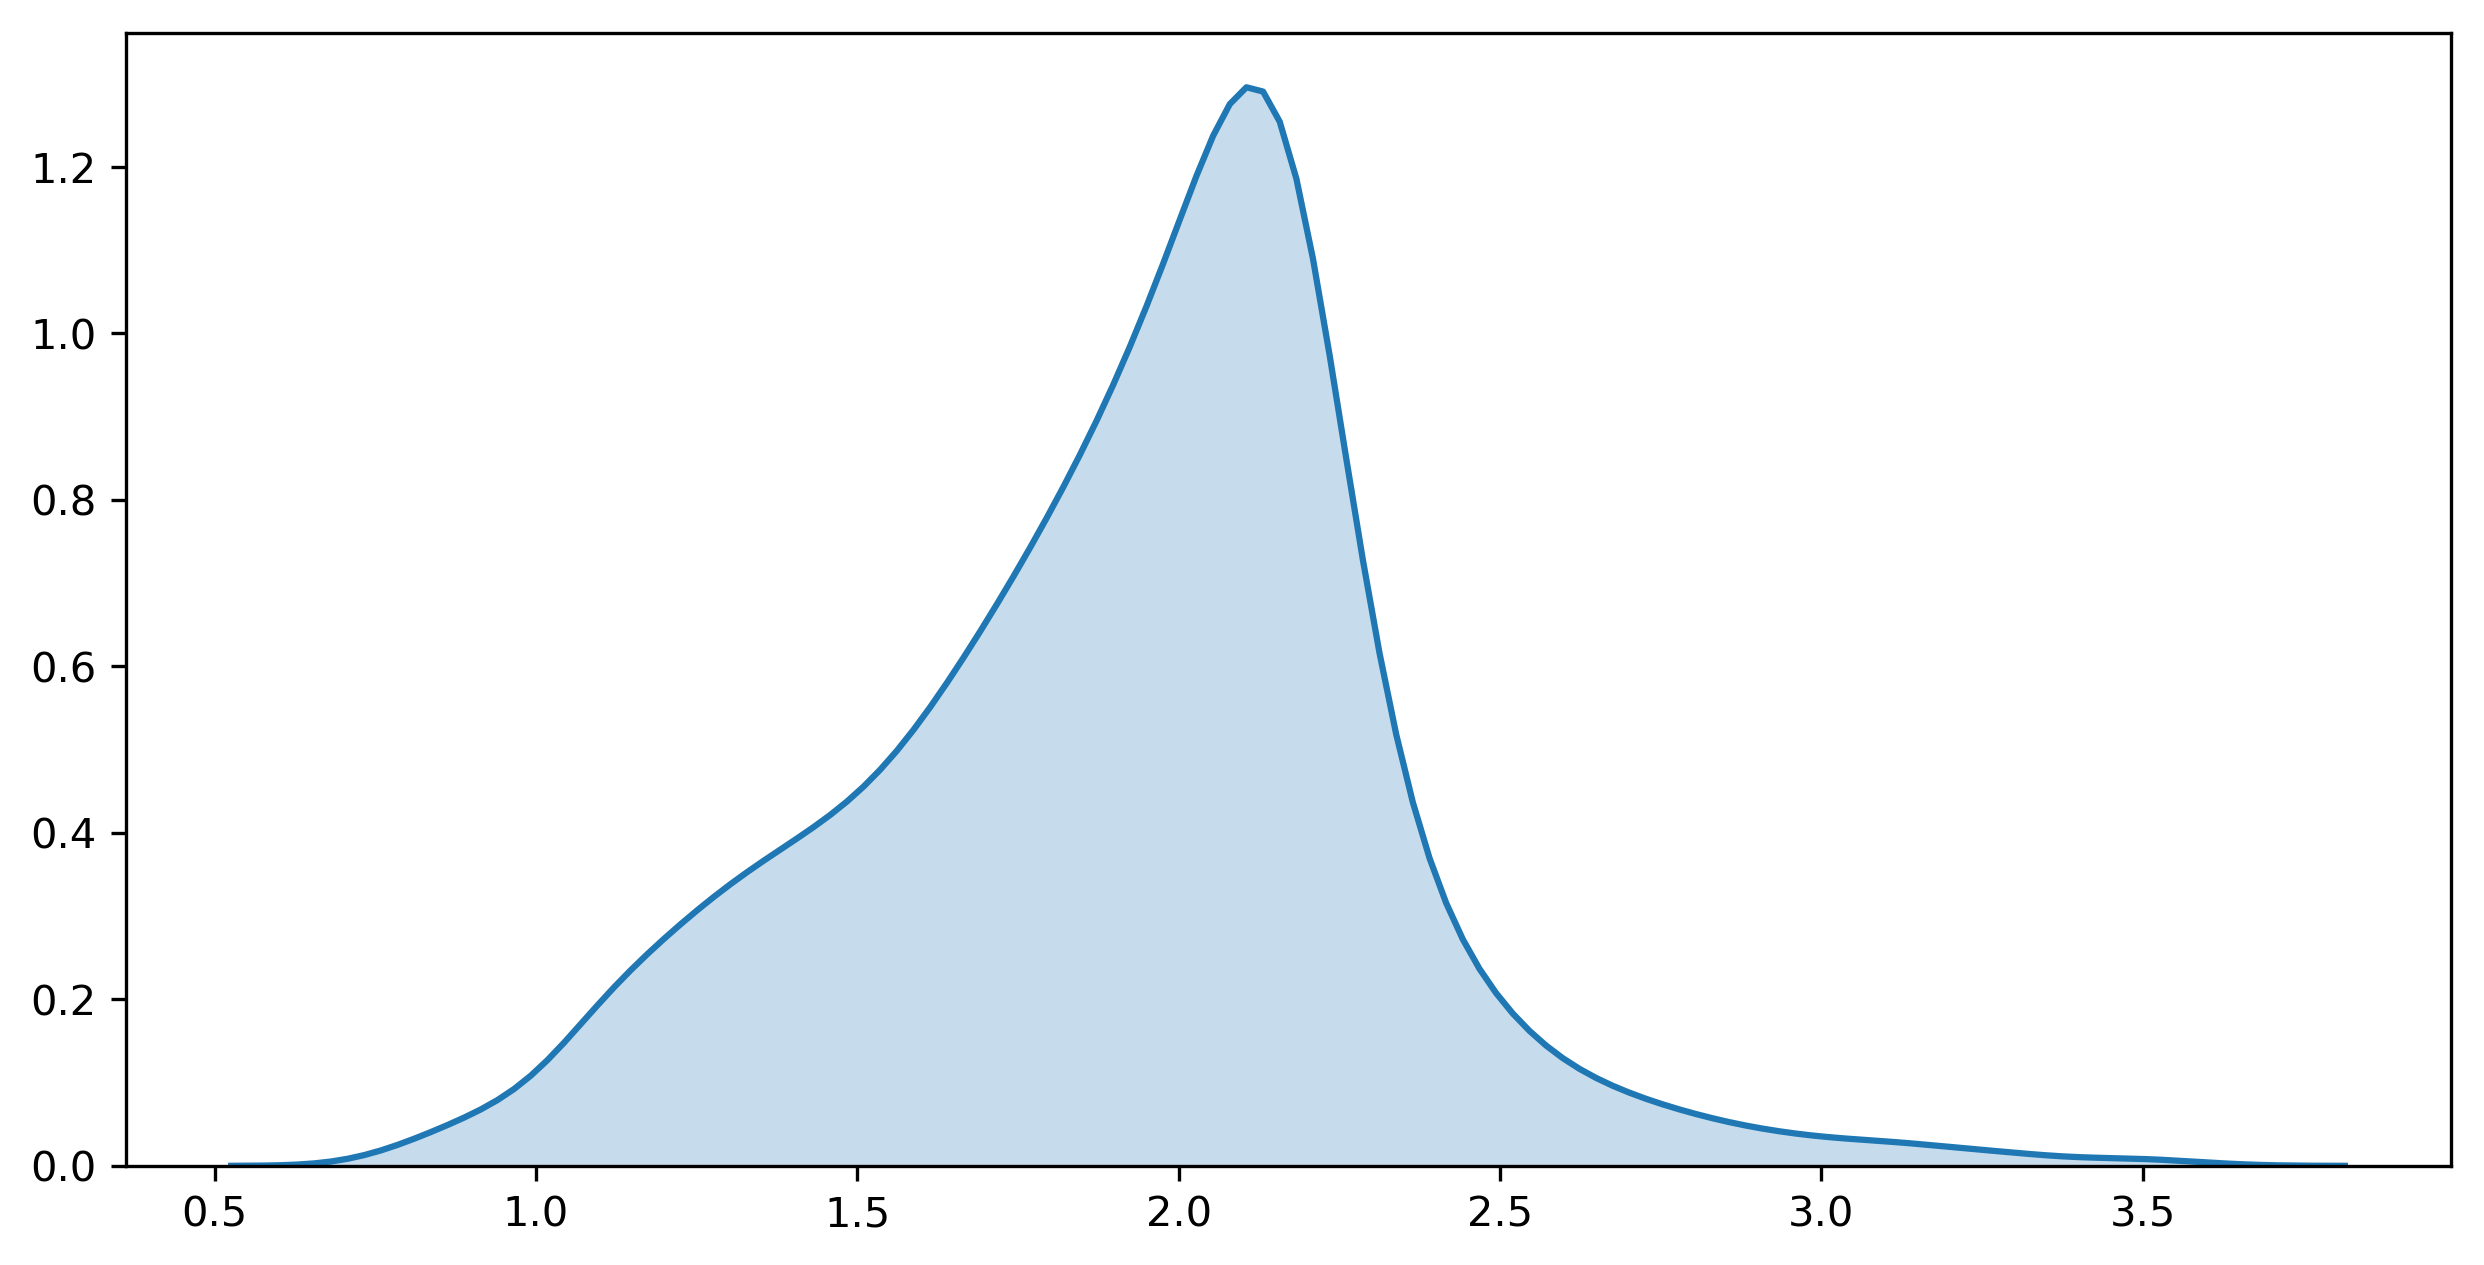

In [71]:
fig, ax = plt.subplots(figsize=(10,5), dpi=300)
sns.kdeplot(dtl_costs, shade=True, ax=ax)

In [82]:
d3 = [(x,y,z) for (x, y), z in zip(itertools.product(range(1,51), range(1,51)), dtl_costs)]
df = pd.DataFrame(data=d3, columns=['D', 'T', 'dtl_ratio'])
df.head()

,D,T,dtl_ratio
0,1,1,2.333333
1,1,2,3.250000
2,1,3,3.400000
3,1,4,3.500000
4,1,5,3.571429


In [86]:
fig.gca?

Text(0.5, 0, 'DTL cost and sum of penalties ratio')

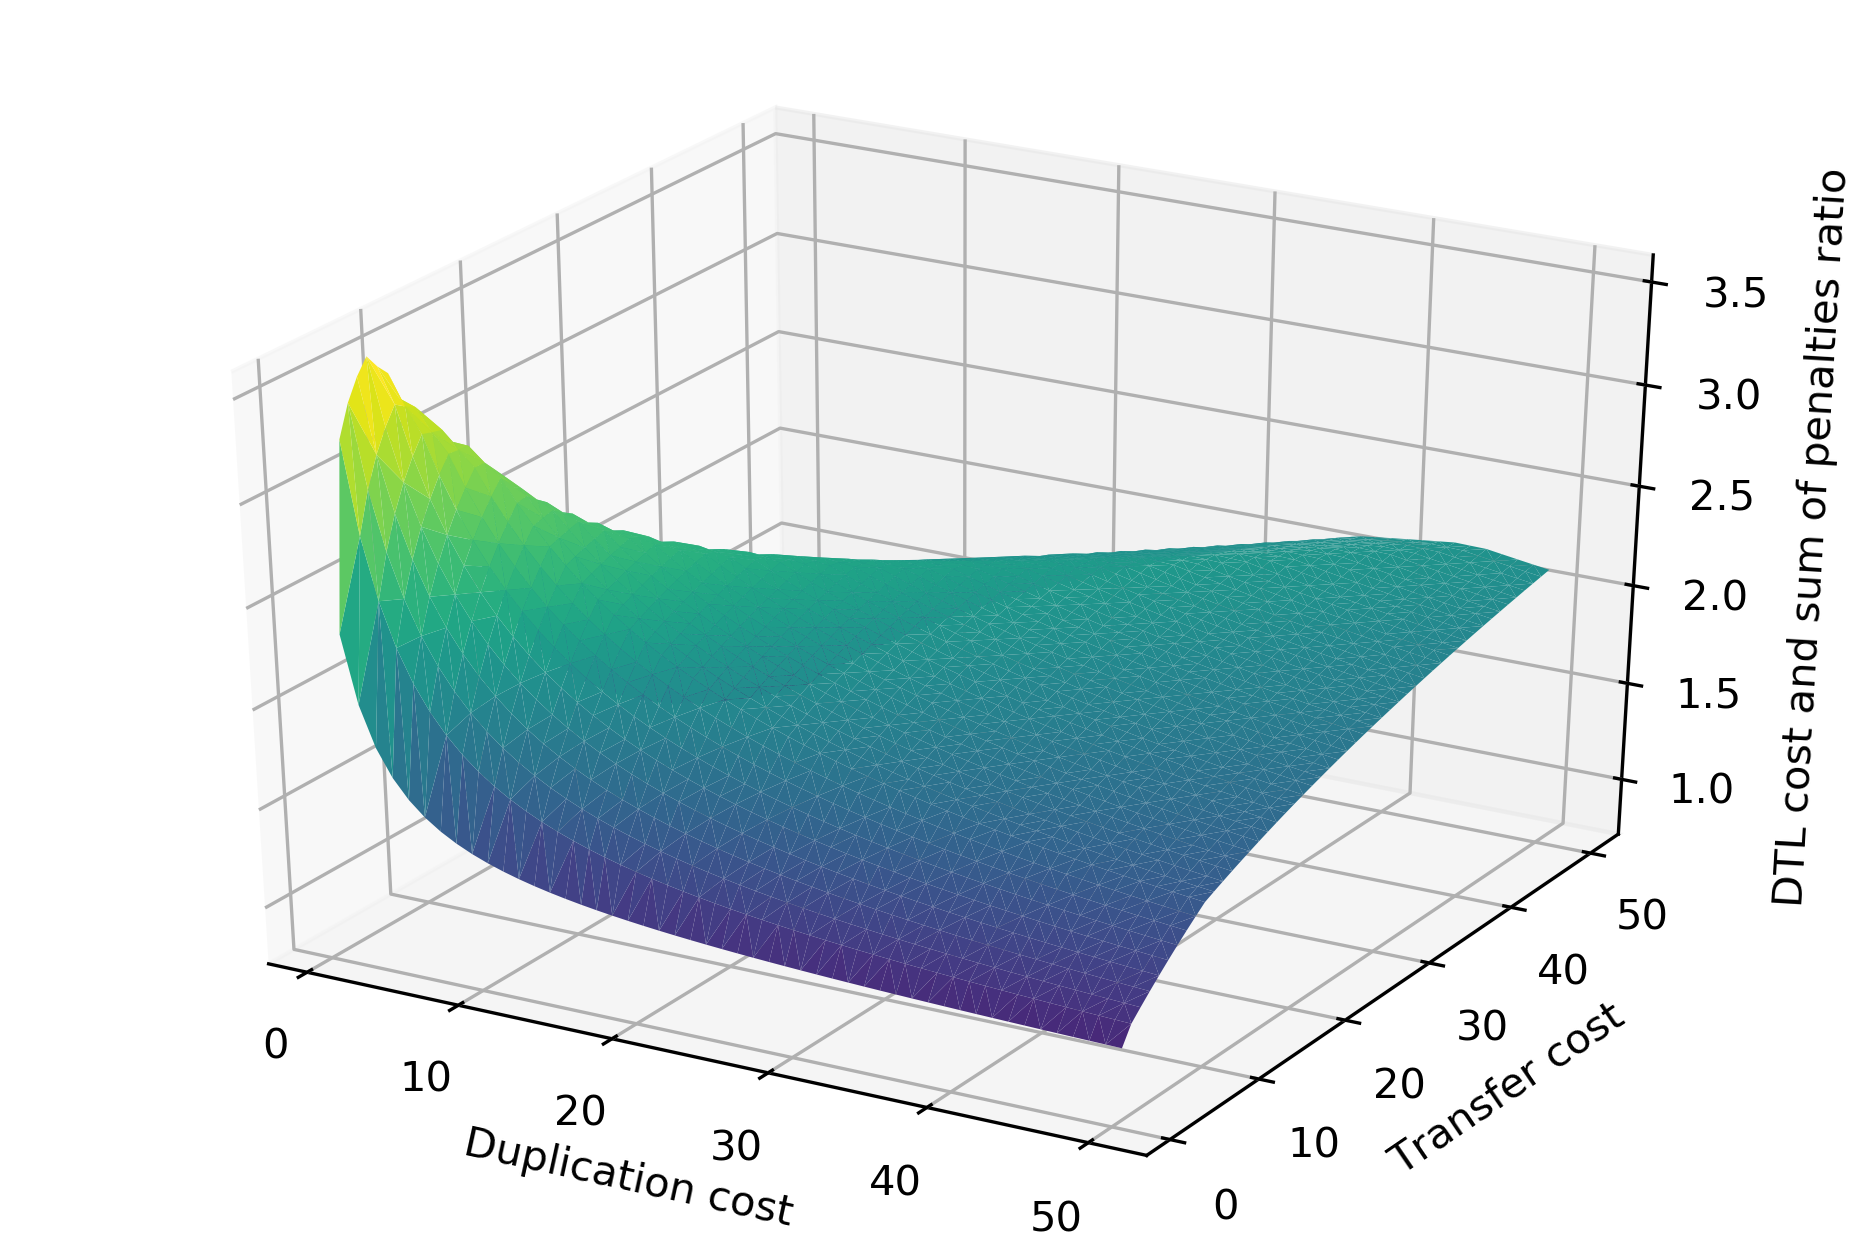

In [108]:
fig = plt.figure(dpi=300)
ax = Axes3D(fig) 
ax.plot_trisurf(df['D'], df['T'], df['dtl_ratio'], cmap=plt.cm.viridis, linewidth=0.2)
ax.set_xlabel('Duplication cost')
ax.set_ylabel('Transfer cost')
ax.set_zlabel('DTL cost and sum of penalties ratio')

In [102]:
dtl_costs[1000]

1.173913043478261

In [105]:
df.dtl_ratio.argmin()

/Users/thiberio/anaconda2/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  """Entry point for launching an IPython kernel.


49

In [107]:
df.loc[49]

D             1.000000
T            50.000000
dtl_ratio     0.769231
Name: 49, dtype: float64